In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from IPython.display import display
from wordcloud import WordCloud
from scipy.stats.mstats import winsorize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set_theme(style="whitegrid", palette="Set2")  
BASE_PALETTE = sns.color_palette()

plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.2,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "grid.alpha": 0.4,
    "grid.linestyle": "--"
})

In [2]:
df = pd.read_csv('data/preprocessed_without_scaling.csv')
df.head(3)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Calories,sugar_g,serving_size_g,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,sodium_g,cholesterol_g,Carbs,Proteins,Fats,meal_name
0,35,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,1.50,4,2,24.87,3,1806.0,31.77,120.47,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,3,Legs,Lats,Dumbbell flyes,1.72994,0.28505,267.68,106.05,71.63,Grilled Vegan Lunch
1,23,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,1.90,4,2,23.48,3,1577.0,12.34,109.15,1.92,Bear Crawls,4,16,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,2,Chest,Lats,Lateral raises,0.69308,0.30061,214.32,85.41,56.97,Fried Vegetarian Lunch
2,33,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,1.88,3,1,21.15,2,1608.0,42.81,399.43,4.70,Dips,5,22,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,2,Arms,Grip Strength,Standing calf raises,2.14248,0.21542,246.04,98.11,65.48,Boiled Paleo Breakfast


In [3]:
df['diet_type'] = df['meal_name'].str.split().str[1]
input_features = [
    'Age',
    'Gender',
    'Weight (kg)',
    'Height (m)',
    'BMI',
    'Experience_Level',
    'Workout_Frequency (days/week)',
    'Daily meals frequency',
    'diet_type'
]


df_user_data = df[input_features]
df_user_data.head(3)

,Age,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days/week),Daily meals frequency,diet_type
0,35,Male,65.27,1.62,24.87,2,4,3,Vegan
1,23,Female,56.41,1.55,23.48,2,4,3,Vegetarian
2,33,Female,58.98,1.67,21.15,1,3,2,Paleo


Encoding of categorical features Genger and Diet type.

In [4]:
df_user_data = pd.get_dummies(df_user_data, columns=['Gender', 'diet_type'])
df_user_data.head(3)

,Age,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days/week),Daily meals frequency,Gender_Female,Gender_Male,diet_type_Balanced,diet_type_Keto,diet_type_Low-Carb,diet_type_Paleo,diet_type_Vegan,diet_type_Vegetarian
0,35,65.27,1.62,24.87,2,4,3,False,True,False,False,False,False,True,False
1,23,56.41,1.55,23.48,2,4,3,True,False,False,False,False,False,False,True
2,33,58.98,1.67,21.15,1,3,2,True,False,False,False,False,True,False,False


In [5]:
numeric_cols = ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 
                'Workout_Frequency (days/week)', 'Daily meals frequency']

mean_dict = {}
std_dict = {}

for col in numeric_cols:
    mean = df_user_data[col].mean()
    std = df_user_data[col].std()
    mean_dict[col] = mean
    std_dict[col] = std
    df_user_data[col + '_scaled'] = (df_user_data[col] - mean) / std

scaled_numeric_cols = [col + '_scaled' for col in numeric_cols]
categorical_scaled_cols = [c for c in df_user_data.columns if c not in numeric_cols and '_scaled' not in c]
final_features = scaled_numeric_cols + categorical_scaled_cols

X = df_user_data[final_features].values
df_user_data[final_features].head(3)

,Age_scaled,Weight (kg)_scaled,Height (m)_scaled,BMI_scaled,Workout_Frequency (days/week)_scaled,Daily meals frequency_scaled,Experience_Level,Gender_Female,Gender_Male,diet_type_Balanced,diet_type_Keto,diet_type_Low-Carb,diet_type_Paleo,diet_type_Vegan,diet_type_Vegetarian
0,-0.321350,-0.403548,-0.811881,-0.001794,0.743868,0.211608,2,False,True,False,False,False,False,True,False
1,-1.312164,-0.823087,-1.362754,-0.210191,0.743868,0.211608,2,True,False,False,False,False,False,False,True
2,-0.486485,-0.701392,-0.418400,-0.559517,-0.351407,-1.360622,1,True,False,False,False,False,True,False,False


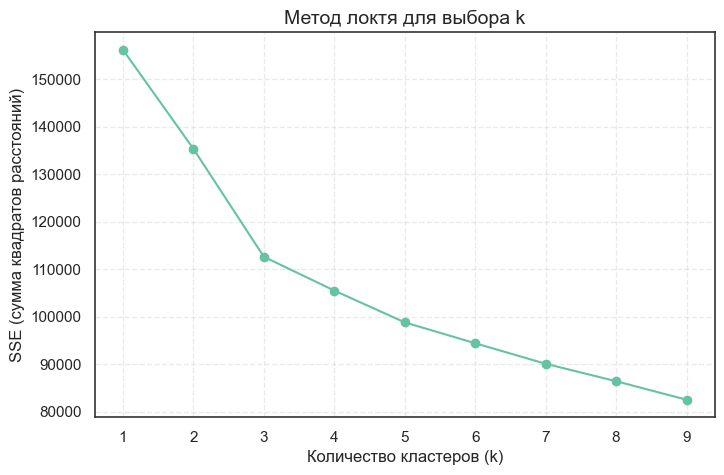

In [6]:
sse = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('SSE (сумма квадратов расстояний)')
plt.title('Метод локтя для выбора k')
plt.show()

In [7]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
df_user_data['Cluster'] = kmeans.labels_

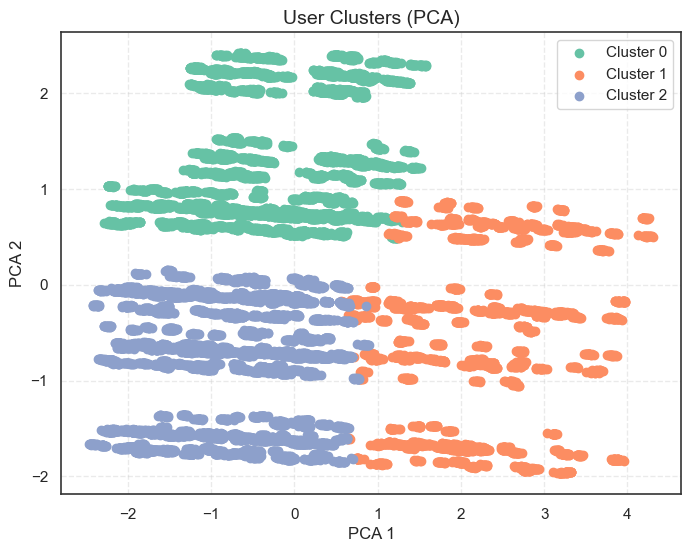

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for cluster in range(3):
    plt.scatter(
        X_pca[df_user_data['Cluster'] == cluster, 0],
        X_pca[df_user_data['Cluster'] == cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('User Clusters (PCA)')
plt.legend()
plt.show()

In [9]:
columns = [
    "Age",
    "Weight (kg)",
    "Height (m)",
    "BMI",
    "Experience_Level",
    "Workout_Frequency (days/week)",
    "Daily meals frequency",
    "Gender_Female",
    "Gender_Male",
    "diet_type_Balanced",
    "diet_type_Keto",
    "diet_type_Low-Carb",
    "diet_type_Paleo",
    "diet_type_Vegan",
    "diet_type_Vegetarian"
]

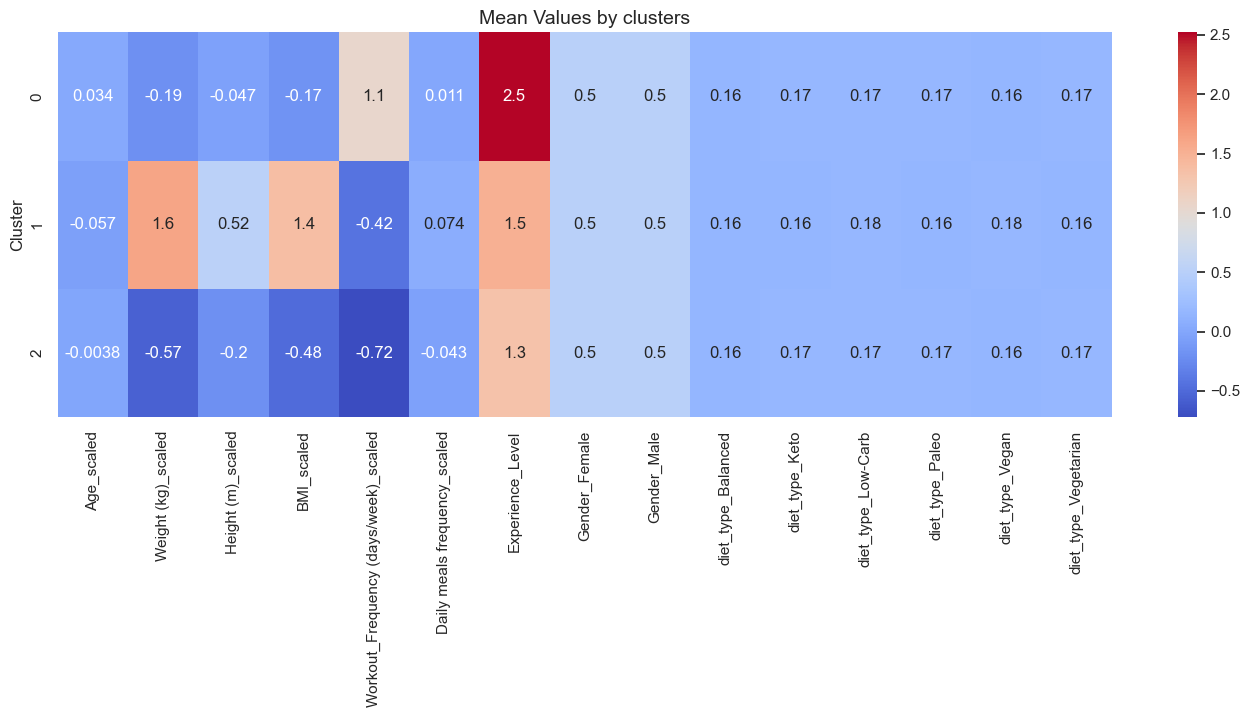

In [10]:
cluster_means = df_user_data.groupby('Cluster')[scaled_numeric_cols + categorical_scaled_cols].mean()

plt.figure(figsize=(17,5))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm')
plt.title('Mean Values by clusters')
plt.show()


In [11]:
new_user = pd.DataFrame([{
    'Age': 38,
    'Weight (kg)': 100,
    'Height (m)': 1.70,
    'BMI': 34.6,
    'Workout_Frequency (days/week)': 3,
    'Daily meals frequency': 2,
    'Gender': 'Female',
    'diet_type': 'Low-Carb'
}])

new_user_encoded = pd.get_dummies(new_user, columns=['Gender', 'diet_type'])

# Добавляем отсутствующие колонки с нулями
for col in categorical_scaled_cols:
    if col not in new_user_encoded.columns:
        new_user_encoded[col] = 0

# Стандартизируем числовые признаки
for col in numeric_cols:
    new_user_encoded[col + '_scaled'] = (new_user_encoded[col] - mean_dict[col]) / std_dict[col]

X_new = new_user_encoded[final_features].values
cluster_new_user = kmeans.predict(X_new)
print("New user's cluster id:", cluster_new_user[0])

New user's cluster id: 1
